In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import statsmodels.api as sm
from scipy import stats
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import random

from math import sqrt

from scipy.signal import butter,filtfilt
import numpy as np
from scipy.signal import butter,filtfilt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [2]:
import skfda
from skfda.ml.clustering import FuzzyCMeans, KMeans
class OSLFuzzyCluster:
    '''
    Class for fuzzy clustering 
    '''
    def __init__(self,data,n_cluster=3,init_cluster=None,fuzzifier=2):
        self.data = data
        self.nclust = n_cluster
        self.init_clust = init_cluster
        self.model = None
        self.predictClus = None
        self.fData = None
        self.fuzzifier=fuzzifier
        self.probCond = None
    
    def getFDataGrid(self, inp):
        '''
        This function provides data transformation for the fuzzyCMeans package.
        We provide a multi-dimensional list and transform to a FDataGrid datatype
        '''
        inp = np.array(inp)
        n_dim = inp.ndim
        if n_dim == 1:
            grid_point = list(range(len(inp)))
            data_grid = []
            data_grid.append(inp)
            fd = skfda.FDataGrid(data_grid,grid_point)
            return fd
        elif n_dim == 2:
            grid_point = list(range(len(inp[0])))
            data_grid = []
            for i in range(len(inp)):
                data_grid.append(inp[i])

            fd = skfda.FDataGrid(data_grid,grid_point)
            return fd
        else:
            raise Exception("Cannot handle more than 2 dimension for now") 
            return None
    
    def update_data(self,data):
        '''
        This function allows to add more data to the object for future clustering 
        '''
        self.data = np.append(self.data,np.array(data))
        return
        
        
    def fit(self):
        '''
        fit() function does two function:
        1. Create a clustering model, which can provide the cluster probability of a data point
        2. Provides predicted cluster probability of the trained data
        '''
        self.fData = self.getFDataGrid(self.data)
        if self.fData == None:
            print("No data to cluster")
            return None
        self.model = FuzzyCMeans(n_clusters=self.nclust,n_init=5 ,init=self.init_clust,fuzzifier=self.fuzzifier,max_iter=400,random_state=0)
        self.model.fit(self.fData)
        self.predictClus = self.model.predict_proba(self.fData)
        return self.model,self.predictClus
    
    def predict_clust(self,data):
        '''
        User function to get the cluster probability of a given data point
        '''
        fd = self.getFDataGrid(data)
        return self.model.predict_proba(fd)
    
    def get_center(self):
        '''
        Allows us to get the cluster centers
        '''
        return self.model.cluster_centers_.data_matrix
        
    def get_CondProb(self):
        '''
        Provides the transitional probability among different clusters for the trained data
        '''
        prob_count = self.predictClus
        n_cluster = self.nclust

        PCount = [0 for _ in range(n_cluster)]
        PTP_count = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
        for i in range(len(prob_count)):
            for c in range(n_cluster):
                PCount[c] += prob_count[i][c]
                if i>0:
                    for cn in range(n_cluster):
                        PTP_count[cn][c] += prob_count[i-1][cn]*prob_count[i][c]


        self.probCond = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
        for i in range(n_cluster):
            for j in range(n_cluster):
                self.probCond[i][j] = round(PTP_count[i][j]/PCount[i],3) # P(Y(t) in j / Y(t-1) in i)
        return self.probCond
    

        

In [3]:
import statsmodels.api as sm
class OSLARMA:
    def __init__(self,endog,p=3,q=0,exog=None,weight=None,shiftQ=5):
#         import statsmodels.api as sm
        self.endog = endog
        self.p = p
        self.q = q
        self.ShQ = shiftQ
        self.exog = np.array(exog)
        self.w = weight # can use np.square or np.sqrt
        self.model = None
        self.MAmodel = None
        self.xData = None
        self.yData = None
        self.ylast = None
        self.fitData = None
        self.residual = None
        self.reslast = None
    
    def summary(self):
        return self.model.summary()
        
    def getShifted_Dataset(self):
        '''
        Creates a shifted dataset for AR module, so we can transform a single dimensional time series
        to a p-dimensional data for AR train and keep some data for the prediciting new data
        '''
        # Currently accepting only one dimensional exog if any
        if self.p < 1:
            print('Error needs atleast 1')
            return None
        plen = self.p
        df_temp = pd.DataFrame()
        df_temp['endog'] = self.endog
        # Getting shifted dataset
        for i in range(1,self.p+1):
            df_temp['Shift_endog_%d' % i] = df_temp['endog'].shift(i)
        if self.exog is not None:
#             df_temp['exog'] = self.exog
#             plen += 1
#             # Shifting the exog variable
            self.exog = np.array(self.exog)
            for xid in range(self.exog.shape[0]):
                df_temp['exog_%d' % xid] = self.exog[xid]
                plen += 1
        if self.w is not None:
            df_temp['Weight'] = self.w
        elif self.w is None:
            df_temp['Weight'] = np.ones(self.endog.shape[0])

        df_train_2 = df_temp.dropna()
        X_train = df_train_2.iloc[:,1:plen+1].values.reshape(-1,plen)
        y_train = df_train_2.iloc[:,0].values.reshape(-1,1)
        sample_weight = df_train_2['Weight'].values
        Y_last = df_train_2.iloc[-1,:self.p].values.reshape(-1,self.p)
        return [y_train,X_train,Y_last[0],sample_weight]
    
    def update_data(self,endog,exog=None,weight=None,residual=None):
        '''
        Update the data which allows to use the recent observation to update the AR history to make accurate
        prediction for future steps, if we want to avoid estimated value leading to a multi-step prediction
        additive error 
        '''
        # Addpending the data
        self.endog = np.concatenate((self.endog,np.array(endog)))
        
        if exog is not None:
            self.exog = np.concatenate((self.exog, np.array(exog).reshape(self.exog.shape[0],1)),axis=1)
        if weight is not None:
            self.w = np.concatenate((self.w,np.array(weight)))
        if residual is not None:
            self.residual = np.concatenate((self.residual,np.array(residual)))
            self.reslast = self.residual[-1:(self.ShQ+self.q+1):-1]
        if residual is None:
            self.reslast = np.zeros(self.ShQ+self.q)
        # This part is helps adding the new observed data and can be used to retrain the model
        self.ylast = self.endog[-1:-(self.p+1):-1]
        
#         #Test Code
#         print("Update",self.ylast)
#         #End testcode
        return
    
    def update_hist(self,endog,exog=None,weight=None,residual=None):
        '''
        This code clears the history data used to train/ fit and can be used
        when the test and train are disjoint data sets
        '''
        self.endog = endog
        if exog is not None:
            self.exog = exog
        if weight is not None:
            self.w = weight
#         if residual in None:
#             self.resl
        
        self.ylast = self.endog[-1:-(self.p+1):-1]
        return
    
    
    def WeighedLearn(self,y,X,weight):
        '''
        This code allows to generate a weighted regression based on the weight and train data
        '''
        X_sm = sm.add_constant(X)
        model = sm.WLS(y,X_sm,weights=weight)
        result = model.fit()
        return result
    
    def AR(self):
        '''
        This code is the AR part of the class.
        We first generate the train data by generating p-shifted data train data. We can also add exog but only on
        
        
        
        '''
        tData = self.getShifted_Dataset()
        self.xData = tData[1]
        self.yData = tData[0]
        self.w = tData[3]
#         self.yData = tData[0]
#         self.xData = tData[1]
        self.ylast = tData[2]
#         weight = tData[3]
        self.model = self.WeighedLearn(tData[0],tData[1],weight=tData[3])
        return self.model,self.ylast,
    
    def MA(self):
        df_res = pd.DataFrame()
        df_res['res'] = self.residual
        
        for i in range(1,self.q+1):
            df_res['shifted_%d' % i] = df_res['res'].shift(self.ShQ+i)
        df_res['weight'] = self.w
        my_data = df_res.dropna()
        X_train = my_data.iloc[:,1:self.q+1].values.reshape(-1,self.q)
        Y_train = my_data.iloc[:,0].values.reshape(-1,1)
        
        self.MAmodel = self.WeighedLearn(Y_train,X_train,weight=my_data['weight'].values)
        #Get the last residual
        self.reslast = my_data.iloc[0:self.ShQ+self.q,0].values.reshape(-1)
        return self.MAmodel
    
    def fit(self):
        mymodel,_ = self.AR()
        y_pred = np.array(self.model.get_prediction(sm.add_constant(self.xData)).predicted_mean)
        df_c = pd.DataFrame()
        df_c['pred'] = y_pred
        df_c['act'] = self.yData
        df_c['res'] = df_c.pred - df_c.act
        self.residual = df_c['res'].values
#         print(self.residual)
        MAModel = self.MA()        
        return mymodel,MAModel
    
    def get_predict(self,exog=None):
        if exog is not None:
            X_test = [1.0]
            X_test.extend(self.ylast)
            X_test.extend(exog)
            y_pred = self.model.get_prediction(X_test).predicted_mean
#             X_rTest = [1.0]
#             X_rTest.extend(self.reslast[self.ShQ:self.ShQ+self.q])
#             y_MApred = self.MAmodel.get_prediction(X_rTest).predicted_mean
#             y_pred =y_pred-y_MApred
            return y_pred
            
           
    def get_ARpredict(self,steps=1,exog=None):
        # Ensure that the exog and model have the same dimension. Currently we have only one dim of exog
        if exog is not None:
            #Update
            if len(exog) != steps:
                print("Exog variable incorrect")
                return None
        # Assume exog is there
        Y_out = []
#         print("exog",exog)
        if exog is not None:
            X_update = []        
            X_inp = self.ylast
#             print("ylast",self.ylast)
            for i in range(steps):
                X_test = [1.0]
                X_test.extend(X_inp)
                X_test.extend(exog[i])
#                 print("Xtest",X_test)
                y_pred = self.model.get_prediction(X_test).predicted_mean
                Y_out.extend(y_pred)
                X_i = list(y_pred)
                X_i.extend(X_inp[:-1])
                X_inp = X_i
#                 print(X_inp)
            # Predict the data
            return Y_out
        else:
            #No exog
            X_inp = self.ylast
            for i in range(steps):
                X_test = [1.0]
                X_test.extend(X_inp)
                y_pred = self.model.get_prediction(X_test).predicted_mean
                Y_out.extend(y_pred)
                X_i = list(y_pred)
                X_i.extend(X_inp[:-1])
                X_inp = X_i
    #             print(X_inp)
            return Y_out        

In [4]:
# Data Modifier Code
def getDataFrame(fileName):
    myDf = pd.read_csv(fileName)
    myDf['memLoad'] = myDf['memUse']*100/myDf['memTot']
    myDf['memScore'] = myDf['memLoad']*myDf['memfreq']/825000000
    myDf['memF'] = myDf['memfreq']*100/825000000
    myDf['cpuScore'] = myDf['cpuload']*myDf['cpufreq']/1400000
    myDf['cpuF'] = myDf['cpufreq']*100/1000000
    return myDf

def getNewDataFrame(fileName):
    myDf = pd.read_csv(fileName)
#     myDf['memLoad'] = myDf['memUse']*100/myDf['memTot']
    myDf['mUtil'] = myDf['mUtil'].clip(upper=100)
    myDf['mScore'] = myDf['mUtil']*myDf['mFreq']/825000000
    myDf['memF'] = myDf['mFreq']*100/825000000
    myDf['bcScore'] = myDf['bUtil']*myDf['bFreq']/1400000
    myDf['bF'] = myDf['bFreq']*100/1400000
    return myDf

def getDataMatrix(dx,dy=None): # dy should be multi-dimensional
    data_matrix=[]
    if dy is None:
        for v in dx:
            data_matrix.append([round(v,2),round(v,2)])
    else:
        n_xog = len(dy)
        n_len = len(dx)
        for i in range(n_len):
            v = []
            v.append(round(dx[i],2))
            for j in range(n_xog):
                v.append(round(dy[j][i],2))
#         for v in zip(dx,dy):
            data_matrix.append(v)
    return data_matrix

In [5]:
from scipy.signal import lfilter
def butter_filter(data, cutoff, fs=2.0, order=2,passtype='low'):
    nyq = 0.5*fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype=passtype, analog=False)
    y = filtfilt(b, a, data)
    y = np.array(y)
    return y
def butter_lfilter(data, cutoff, fs=2.0, order=2,passtype='low'):
    nyq = 0.5*fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype=passtype, analog=False)
    y = lfilter(b, a, data)
    y = np.array(y)
    return y

In [6]:
# Use the FFT filters
from scipy.fft import fft,ifft,fftfreq
def FFTPass(signal,passX=45,pType='low'):
    yfft = fft(signal)
    if pType=='low':
        yfft[passX:-passX] = 0
    elif pType=='high':
        yfft[:passX]=0
        yfft[-passX:]=0
    fSig = ifft(yfft)
    return fSig.real

def windowFFT(signal,W=100,passX=45,pType='low'):
    if passX > W//2:
        passX = W//2
    lSig = len(signal)
    filtSig = FFTPass(signal[0:W],passX,pType)   
    for i in range(1,lSig-W+1):
        newSig = FFTPass(signal[i:i+W],passX,pType)[-1]
        filtSig = np.append(filtSig,newSig)
    return filtSig
#hfilterSig = windowFFT(signal,W=200,passX=10,pType='high')

<Axes: >

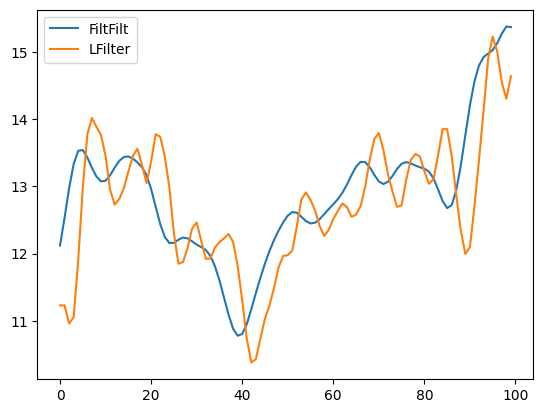

In [7]:
utilData = getNewDataFrame('./UtilTestFinal')
PASS='low'
df_raw = pd.DataFrame()
df_raw['endog'] = utilData.bUtil
dy = np.clip(butter_filter(df_raw.endog.to_numpy(),0.125,passtype=PASS),-100,100)
dz = np.clip(butter_lfilter(df_raw.endog.to_numpy(),0.125,passtype=PASS),-100,100)
df_plot = pd.DataFrame()
df_plot['FiltFilt'] = dy[7600:7700]
df_plot['LFilter'] = dz[7600:7700]
df_plot[['FiltFilt','LFilter']].plot()

In [8]:
# Latest Code
def main(TEST_START=7500,STEP=50,N_CLUST=5,TRAIN_END=7500,ARP=4,PASS='low',FILT=0.25,FTYPE='butter',WFT=100,PX=10):
    utilData = getNewDataFrame('./UtilTestFinal')
#     print("Size of data:",utilData.head())
    ########################################################################
    ########### FORMATTING THE DATA    #####################################
    ########################################################################
    df_raw = pd.DataFrame()
    df_raw['endog'] = utilData.bUtil
    df_raw['exog1'] = utilData.mUtil.diff().shift(1)
    df_raw['exog2'] = utilData.mUtil.diff().shift(1)
    df_data = df_raw.dropna()
    if FTYPE=='butter':
        dy = np.clip(butter_lfilter(df_data.endog.to_numpy(),FILT,passtype=PASS),-100,100)
        dz = np.clip(butter_lfilter(df_data.exog1.to_numpy(),FILT,passtype=PASS),-100,100)
        dx = np.clip(butter_lfilter(df_data.exog2.to_numpy(),FILT,passtype=PASS),-100,100)
    elif FTYPE=='FFT':
        dy = windowFFT(df_data.endog.to_numpy(),W=WFT,passX=PX,pType=PASS)
        dz = windowFFT(df_data.exog1.to_numpy(),W=WFT,passX=PX,pType=PASS)
        dx = windowFFT(df_data.exog2.to_numpy(),W=WFT,passX=PX,pType=PASS)
    else:
        dy = df_data.endog.to_numpy()
        dz = df_data.exog1.to_numpy()
        dx = df_data.exog2.to_numpy()
        
    yACT = df_data.endog.to_numpy()
    nCluster = N_CLUST
    y_train = dy[:TRAIN_END]
    x_train = dz[:TRAIN_END]
    x_train2 = dx[:TRAIN_END]
    # Predicting in a different range
#     TEST_START = 7500
    y_test = dy[TEST_START:]
    x_test = dz[TEST_START:]
    x_test2 = dx[TEST_START:]
    
    
    ####################################################################
    ############## TRAIN THE CLUSTER AND MODEL #########################
    ####################################################################
    
    
    
    y_dmat = getDataMatrix(y_train,[x_train,x_train2])
#     y_dmat = getDataMatrix(y_train)
    myClust = OSLFuzzyCluster(y_dmat,n_cluster=nCluster)
    _, data_weight = myClust.fit()
#     print(dy[0])
#     print(data_weight)
#     print("data_cluster", myClust.get_center())
    trans_prob = myClust.get_CondProb()
    #Removing Print
#     print(trans_prob)
#     print("\n\n\n")
    # We will send the weights of the data and then train these models
    models = []
    # Train the models
    for i in range(nCluster):
        model = OSLARMA(y_train,p=ARP,exog=[x_train,x_train2], weight=data_weight[:,i],q=4,shiftQ=0)
        model.fit()
#         print(model.summary())
        models.append(model)
    
    
    # Error prediction:
    RMSE = []
    MAE = []
    
    ###############################################################
    ####### TEST THE MODEL ########################################
    ###############################################################
    
    
    # Models are trained now begin prediction
#     print("last actual value", y_train[-1],"Likelihood cluster", myClust.predict_clust([ y_train[-1], y_train[-1]]))
    y_prior = dy[TEST_START-1]
    x_prior = dz[TEST_START-1]
    x2_prior = dx[TEST_START-1]
    Y_ACT=[]
    Y_PRED=[]
    res_pred = 0
    for i in range(STEP):
        # Get prob of P(Y(t-1) in i) using cluster
        P_prior = myClust.predict_clust([y_prior,x_prior,x2_prior])[0]
#         P_prior = myClust.predict_clust([y_prior,y_prior])[0]
#         print("P",P_prior)
        P_like = []
        # Predict likelihood of Y(t) in cluster based on transition prob
        for k in range(nCluster):
            prob = 0
            for j in range(nCluster):
                prob += trans_prob[j][k]*P_prior[j]
            P_like.append(prob)
#         print("PLike",P_like)
        
#         print("PLike",P_like)
        y_act = y_test[i]
        y_prior = y_act
        x_prior = dz[TEST_START+i]
        x2_prior = dx[TEST_START+i]
        y_pred = []
        y_est = 0
        for j in range(nCluster):
            y_pred.append(models[j].get_predict([x_prior,x2_prior])[0])
            y_est += y_pred[-1]*P_like[j]
#             if P_like[j] > 0.7:
#                 y_est = y_pred[-1]
#                 break
#         if PASS=='low' and FTYPE=='butter':
        y_est = max(0, min(y_est-res_pred, 100))
        # y_est = y_est-res_pred  
        #####################################################################
        ####### PREDICTION ENDS HERE ########################################
        #####################################################################
        res = y_est - y_act
#         y_est = dy[TEST_START+i-1]
        if abs(res) < 90:      # removing huge state changes
            RMSE.append(res*res)
            MAE.append(abs(res))
        res_pred = 0.5* res + 0.5*res_pred
#         res_pred =  max(-20, min(res_pred, 20))
#         y_prior = y_est
#         print(i, y_act,y_est,x_prior)
        Y_ACT.append(y_act)
        Y_PRED.append(y_est)
        y_prior = y_act
        for j in range(nCluster):           
            models[j].update_data([y_act],exog=[x_prior,x2_prior],residual=[res])
    
    #####################################################################
    ############# PLOT THE RESULTS ######################################
    #####################################################################
    print("RMSE:", sqrt(sum(RMSE[ARP:])/len(RMSE[ARP:])), "  MAE:", sum(MAE[ARP:])/len(MAE[ARP:]))
    df_plot = pd.DataFrame()
    df_plot['Actual'] = Y_ACT[ARP:]
    df_plot['Predicted'] = Y_PRED[ARP:]
    df_plot[['Actual','Predicted']].plot()

# Filtered Prediction
The estimation ends up in a steady state, and does not update if it observes an mismatch with prediction. Need some sort of nudge, where steady state errors can be handled better

## FFT Filter

RMSE: 0.42177168900741024   MAE: 0.26240952774260284


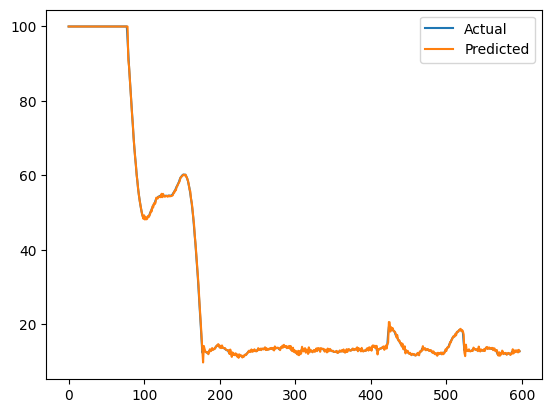

In [9]:
main(TRAIN_END=7500,TEST_START=7500,N_CLUST=4,STEP=600,ARP=2,PASS='low',FILT=0.5,FTYPE='FFT',WFT=100,PX=2)

RMSE: 23.825311334958535   MAE: 14.706716705320696


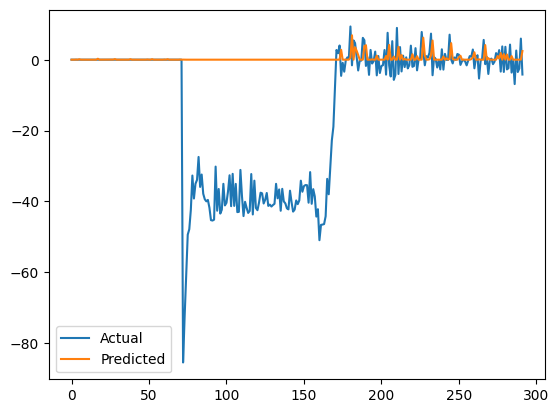

In [10]:
main(TRAIN_END=7500,TEST_START=7500,N_CLUST=15,STEP=300,ARP=8,PASS='high',FILT=0.5,FTYPE='FFT',WFT=100,PX=5)

## Butterworth Filter

RMSE: 1.0186762653285764   MAE: 0.5150255530983868


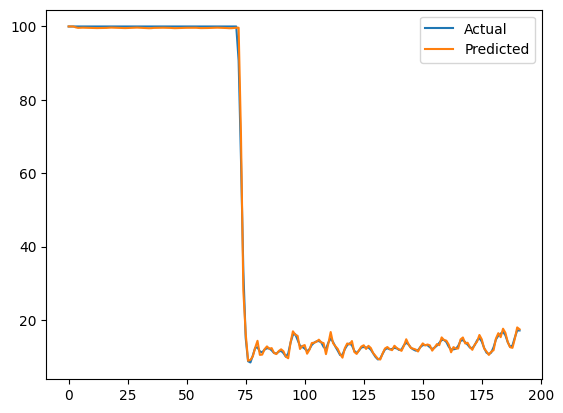

In [11]:
main(TRAIN_END=6000,TEST_START=7500,N_CLUST=4,STEP=200,ARP=8,FILT=0.25)

RMSE: 1.9540418072653911   MAE: 1.022141962559296


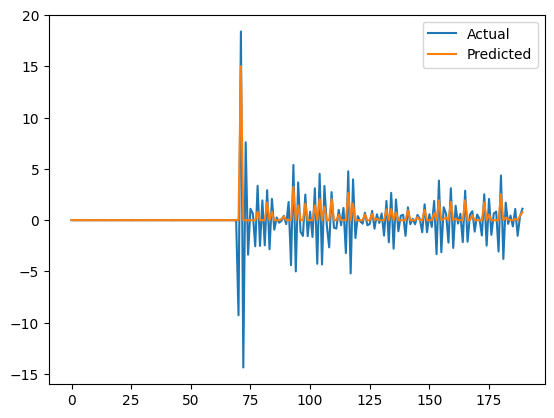

In [12]:
main(TRAIN_END=6000,TEST_START=7500,N_CLUST=10,STEP=200,ARP=10,PASS='high',FILT=0.75)

## No Filter

RMSE: 4.933461128987283   MAE: 3.8709527549387333


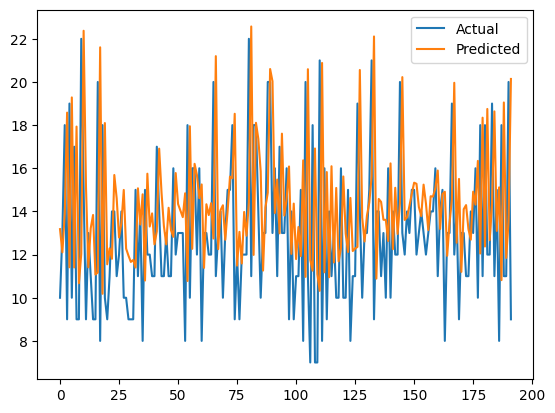

In [13]:
main(TRAIN_END=7600,TEST_START=7600,N_CLUST=10,STEP=200,ARP=8,FTYPE="None",PASS="low")

# Draft Code ( Not used now)

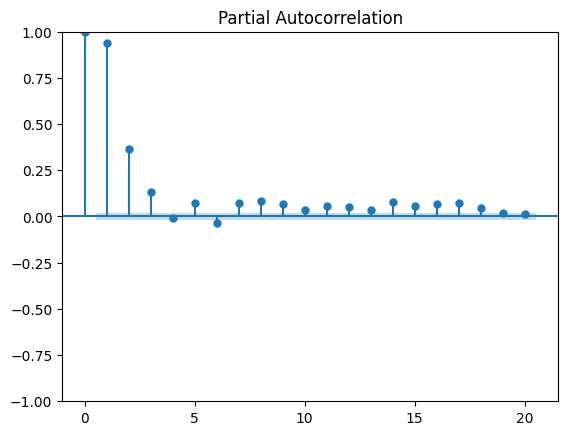

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
utilData = getNewDataFrame('UtilTestFinal')
plot_pacf(utilData['bUtil'].dropna(),lags=20,alpha=0.05,method='ols');
# utilData['sUtil'].iloc[600:6250]

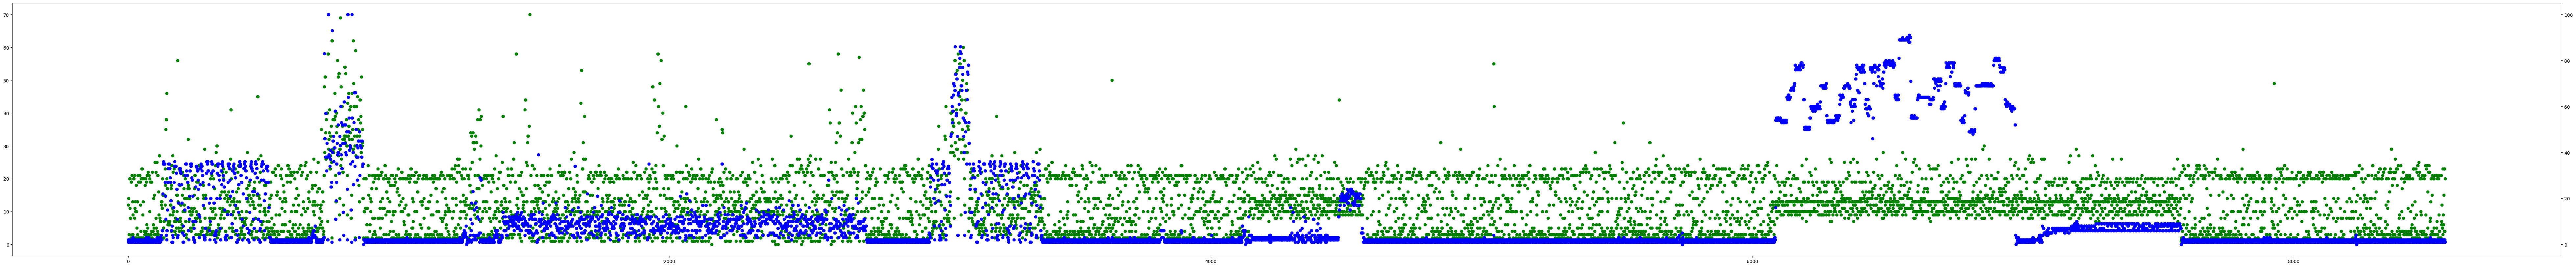

In [15]:
utilData = getNewDataFrame('UtilTestFinal')
# print(utilData.bUtil.diff().shift(1))
fig, ax1 = plt.subplots(figsize=(100,10))

x = utilData.index.values.tolist()
y1 = utilData['bUtil']
y2 = utilData['sUtil']
y3 = utilData['mUtil']

ax2 = ax1.twinx()
# ax3 = ax2.twinx()

ax1.plot(x, y2, 'go')
ax2.plot(x, y3, 'bo')
# ax3.plot(x, y3, 'ro')

In [16]:
# Latest AR Code
def main(TEST_START=7500,STEP=50,N_CLUST=5,TRAIN_END=6001,ARP=4):
    utilData = getNewDataFrame('./UtilTestFinal')
    print("Size of data:",utilData.shape)
    dy = utilData.bUtil.dropna().to_numpy()
    dz = utilData.mUtil.dropna().to_numpy()
#     plot_pacf(dz,lags=20,alpha=0.05)
#     return
#     dy = utilData.cpuload.dropna().to_numpy()
    nCluster = N_CLUST
    y_train = dy[2:TRAIN_END]
    x_train = dz[:TRAIN_END-2]
    # Predicting in a different range
#     TEST_START = 7500
    y_test = dy[TEST_START:]
    x_test = dz[TEST_START-2:]
    
    
    y_dmat = getDataMatrix(y_train,x_train)
    myClust = OSLFuzzyCluster(y_dmat,n_cluster=nCluster)
    _, data_weight = myClust.fit()
#     print(dy[0])
#     print(data_weight)
#     print("data_cluster", myClust.get_center())
    trans_prob = myClust.get_CondProb()
    #Removing Print
#     print(trans_prob)
#     print("\n\n\n")
    # We will send the weights of the data and then train these models
    models = []
    # Train the models
    for i in range(nCluster):
        model = OSLARMA(y_train,p=ARP,exog=x_train, weight=data_weight[:,i])
        model.AR()
#         print(model.summary())
        models.append(model)
    
    # Models are trained now begin prediction
#     print("last actual value", y_train[-1],"Likelihood cluster", myClust.predict_clust([ y_train[-1], y_train[-1]]))
    y_prior = dy[TEST_START-1]
    x_prior = dz[TEST_START-3]
    Y_ACT=[]
    Y_PRED=[]
    for i in range(STEP):
        # Get prob of P(Y(t-1) in i) using cluster
        P_prior = myClust.predict_clust([y_prior,x_prior])[0]
#         print("P",P_prior)
        P_like = []
        # Predict likelihood of Y(t) in cluster based on transition prob
        for k in range(nCluster):
            prob = 0
            for j in range(nCluster):
                prob += trans_prob[j][k]*P_prior[j]
            P_like.append(prob)
        
#         print("PLike",P_like)
        y_act = y_test[i]
        y_prior = y_act
        x_prior = dz[TEST_START-2+i]
        y_pred = []
        y_est = 0
        for j in range(nCluster):
            y_pred.append(models[j].get_ARpredict(1,[x_prior])[0])
            y_est += y_pred[-1]*P_like[j]
        
#         print(i, y_act,y_est,x_prior)
        Y_ACT.append(y_act)
        Y_PRED.append(y_est)
        for j in range(nCluster):
            models[j].update_data([y_act],[x_prior])
    df_plot = pd.DataFrame()
    df_plot['Actual'] = Y_ACT
    df_plot['Predicted'] = Y_PRED
    df_plot[['Actual','Predicted']].plot()

In [17]:
# Old Code
# Testing  
def main():
    utilData = getDataFrame('./Util_Run1.csv')
    dy = utilData.cpuload.dropna().to_numpy()
    dz = utilData.memLoad.dropna().to_numpy()
#     dy = utilData.cpuload.dropna().to_numpy()
    nCluster = 5
    y_train = dy[:2000]
    x_train = dz [:2000]
    y_test = dy[2000:]
    x_test = dz[2000:]
    y_dmat = getDataMatrix(y_train,x_train)
    myClust = OSLFuzzyCluster(y_dmat,n_cluster=nCluster)
    _, data_weight = myClust.fit()
#     print(dy[0])
#     print(data_weight)
#     print("data_cluster", myClust.get_center())
    trans_prob = myClust.get_CondProb()
    print(trans_prob)
    print("\n\n\n")
    # We will send the weights of the data and then train these models
    models = []
    # Train the models
    for i in range(nCluster):
        model = OSLARMA(y_train,p=4,exog=x_train, weight=data_weight[:,i])
        model.fit()
#         print(model.summary())
        models.append(model)
    
    # Models are trained now begin prediction
#     print("last actual value", y_train[-1],"Likelihood cluster", myClust.predict_clust([ y_train[-1], y_train[-1]]))
    y_prior = y_train[-1]
    x_prior = x_train[-1]
    for i in range(50):
        # Get prob of P(Y(t-1) in i) using cluster
        P_prior = myClust.predict_clust([y_prior,x_prior])[0]
#         print("P",P_prior)
        P_like = []
        # Predict likelihood of Y(t) in cluster based on transition prob
        for k in range(nCluster):
            prob = 0
            for j in range(nCluster):
                prob += trans_prob[j][k]*P_prior[j]
            P_like.append(prob)
        
#         print("PLike",P_like)
        y_act = y_test[i]
        y_prior = y_act
        x_prior = x_test[i]
        y_pred = []
        y_est = 0
        for j in range(nCluster):
            y_pred.append(models[j].get_predict(1,[x_prior])[0])
            y_est += y_pred[-1]*P_like[j]
        
        print(i, y_act,y_est,x_prior)
        
        for j in range(nCluster):
            models[j].update_data([y_act],[x_prior])
            

    

In [18]:
# main()